In [1]:
# download and install the code

%%bash
# make this cell an instance of a terminal

git clone -b dev https://github.com/katherinekarababas/sodapop-em.git # download code repository from https://github.com/landryp/sodapop/tree/dev

mkdir /opt/bin /opt/lib/ /opt/lib/python3.7 /opt/lib/python3.7/site-packages # create install directory and make it findable
export PATH=$PATH:/opt/bin
export PYTHONPATH=$PYTHONPATH:/opt/lib/python3.7/site-packages

cd sodapop-em # install code
python3 setup.py install --prefix /opt/

python3 -m pip install emcee # also install emcee package to handle markov-chain monte carlo sampling

echo -e '\n *** \n'

sample-pop-params -h # this is the executable from sodapop that draws samples in the population model's parameters (e.g. mmin and mmax); print its help string to see the syntax for calling it

echo -e '\n *** \n'

infer-pop-params -h # this is the executable from sodapop that calculates the posterior probability of the sampled population parameters; print its help string to see the syntax for calling it

echo -e '\n *** \n'

build-ppd -h # this is the executable that postprocesses the population posterior samples to calculate the inferred mass distribution; print its help string to see the syntax for calling it

echo -e '\n *** \n'

running install
running bdist_egg
running egg_info
creating sodapop.egg-info
writing sodapop.egg-info/PKG-INFO
writing dependency_links to sodapop.egg-info/dependency_links.txt
writing top-level names to sodapop.egg-info/top_level.txt
writing manifest file 'sodapop.egg-info/SOURCES.txt'
writing manifest file 'sodapop.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/sodapop
copying sodapop/priors.py -> build/lib/sodapop
copying sodapop/diagnostics.py -> build/lib/sodapop
copying sodapop/parameters.py -> build/lib/sodapop
copying sodapop/emcee.py -> build/lib/sodapop
copying sodapop/select.py -> build/lib/sodapop
copying sodapop/__init__.py -> build/lib/sodapop
copying sodapop/populations.py -> build/lib/sodapop
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/sodapop
copying build/lib/sodapop/priors.py -> buil

Cloning into 'sodapop-em'...
zip_safe flag not set; analyzing archive contents...


In [2]:
#population inference

# observations
PATH = 'sodapop-em/etc/' 
likelihood = 'BNS_0_reweighted.csv,BNS_1_reweighted.csv,BNS_2_reweighted.csv,BNS_3_reweighted.csv,BNS_4_reweighted.csv,BNS_5_reweighted.csv,BNS_6_reweighted.csv,BNS_7_reweighted.csv,BNS_8_reweighted.csv,BNS_9_reweighted.csv,BNS_10_reweighted.csv,BNS_11_reweighted.csv,BNS_12_reweighted.csv,BNS_13_reweighted.csv,BNS_14_reweighted.csv,BNS_15_reweighted.csv,BNS_16_reweighted.csv,BNS_17_reweighted.csv,BNS_18_reweighted.csv,BNS_19_reweighted.csv'
dat_type = 'bns,bns,bns,bns,bns,bns,bns,bns,bns,bns,bns,bns,bns,bns,bns,bns,bns,bns,bns,bns' 
likelihood_num = 100 

# population model using the power law in masses where the convention is m1 >= m2
pop_mod = 'power_m1m2' 
cb_mod = 'unif_m1_power_m2_qpair' 
pop_param = 'mmin,mmax+flat12,1.,1.5,1.5,3. alpha+flat,-1.,1.' #added a parameter for alpha here; need alpha centered around zero so trying these bounds(??)
mcmc_start = 'mmin,mmax+flat12,1.,1.4,1.8,2.4 alpha+flat,-0.1,0.1' #trying with an alpha parameter here too

# selection effect
chirp_mass = 'chirpmass52' 
samp_num = 1000 #number of samples to use for monte carlo calculation of detection fraction

# mcmc algorithm
walks = 10 #number of walkers for mcmc
post_samp = 100 #only start saving posterior samples after this number of steps
post_num = 1000 #number of posterior samples to aim for

# postprocessing
pop_num = 1000 #how many population models to average when computing inferred mass distribution

In [3]:
# draw population parameter samples from model

%%bash -s "$pop_mod" "$walks" "$mcmc_start"
# this cell is a separate terminal instance; with the -s option we are passing the variables we defined above into the terminal as $1,$2,...

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python3.7/site-packages

sample-pop-params $1 -n $2 -p $3 -o ${1}_prior.csv -v # call the executable that draws the starting samples for the mcmc algorithm
# sample-pop-params [population model] -n [number of mcmc walkers] -p [distribution to draw population parameters from] -o [path where population samples should be output]

In [4]:
# do the population inference based on the gravitational-wave observations

%%bash -s "$likelihood" "$pop_mod" "$PATH" "$cb_mod" "$dat_type" "$likelihood_num" "$pop_param" "$chirp_mass" "$samp_num" "$post_num" "$walks" "$post_samp"

export PATH=$PATH:/opt/bin
export PYTHONPATH=$PYTHONPATH:/opt/lib/python3.7/site-packages

IFS=',' read -r -a likes <<< "$1" # some bash magic to turn the lists into arrays
IFS=',' read -r -a classes <<< "$5"

infer-pop-params ${2}_prior.csv $(for like in "${likes[@]}"; do echo -n "${3}/${like} "; done) -p $2 $4 -C $(for class in "${classes[@]}"; do echo -n "${class} "; done) -c m1_source m2_source dL z likelihood -l $6 -P $7 -B 3. 60. 0. -f $8 -s $9 -t ${10} -w ${11} -b ${12} -o ${2}.csv --diag -v # call the executable that runs the mcmc algorithm
# infer-pop-params [prior samples] [likelihood1 likelihood2 ...] -p [bns_pop_model nsbh_pop_model] -C [bns bns  ...] -c [likelihood column names] -l [number of likelihood samples] -P [prior distribution] -B [fixed black hole population parameters] -f [selection function] -s [number of selection samples] -t [number of posterior samples] -w [number of walkers] -b [number of burn-in samples] -o [path where posterior samples should be output]

walkers: 10, burn in: 100, target posterior samples: 1000, likelihood samples: 100, selection effect samples: 1000
Loading likelihood data...
sodapop-em/etc//BNS_0_reweighted.csv
sodapop-em/etc//BNS_1_reweighted.csv
sodapop-em/etc//BNS_2_reweighted.csv
sodapop-em/etc//BNS_3_reweighted.csv
sodapop-em/etc//BNS_4_reweighted.csv
sodapop-em/etc//BNS_5_reweighted.csv
sodapop-em/etc//BNS_6_reweighted.csv
sodapop-em/etc//BNS_7_reweighted.csv
sodapop-em/etc//BNS_8_reweighted.csv
sodapop-em/etc//BNS_9_reweighted.csv
sodapop-em/etc//BNS_10_reweighted.csv
sodapop-em/etc//BNS_11_reweighted.csv
sodapop-em/etc//BNS_12_reweighted.csv
sodapop-em/etc//BNS_13_reweighted.csv
sodapop-em/etc//BNS_14_reweighted.csv
sodapop-em/etc//BNS_15_reweighted.csv
sodapop-em/etc//BNS_16_reweighted.csv
sodapop-em/etc//BNS_17_reweighted.csv
sodapop-em/etc//BNS_18_reweighted.csv
sodapop-em/etc//BNS_19_reweighted.csv
emcee ran for 20.3265860080719 seconds
autocorrelation lengths for population parameters are [32.24479237 49

/opt/lib/python3.7/site-packages/sodapop-0.0-py3.7.egg/sodapop/emcee.py:39: RuntimeWarning: divide by zero encountered in log
/opt/lib/python3.7/site-packages/sodapop-0.0-py3.7.egg/sodapop/emcee.py:15: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 22;
tau: [32.24479237 49.1013057  34.4611722 ]


In [5]:
# calculate the inferred mass distribution from the population posterior samples

%%bash -s "$pop_mod" "$samp_num" "$chirp_mass" "$pop_num"

export PATH=$PATH:/opt/bin
export PYTHONPATH=$PYTHONPATH:/opt/lib/python3.7/site-packages

build-ppd ${1}.csv -p $1 -s $2 -f $3 -m $4 -o ${1}_ppd.csv -v # call the executable that draws the starting samples for the mcmc algorithm
# build-ppd [posterior samples] -p [population model] -s [number of selection effect samples] -f [selection function] -m [number of population models to average] -o [path where inferred mass distribution should be output]

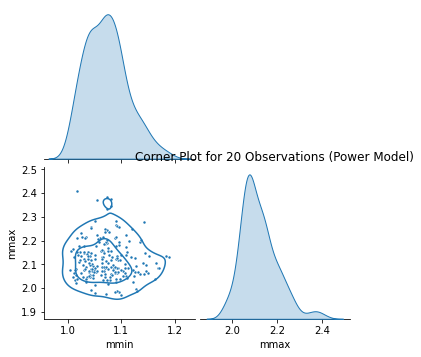

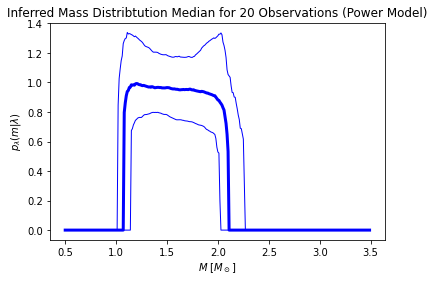

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#corner plot

post_dat = np.genfromtxt(pop_mod+'.csv',delimiter=',',names=True,dtype=None)

params = post_dat.dtype.names[1:3] 
post = np.column_stack([post_dat[param] for param in params]) 
post_frame = pd.DataFrame(post,columns=params)

fig = sns.pairplot(post_frame, kind='scatter', markers='.', diag_kind='kde', corner=True, diag_kws=dict(lw=1,common_norm=False))
fig.map_lower(sns.kdeplot, levels=[0.1,0.5]) 

plt.title ('Corner Plot for 20 Observations (Power Model)')
plt.show()

ppd_data = np.genfromtxt(pop_mod+'_ppd.csv',delimiter=',',names=True,dtype=None) 

colours = plt.rcParams['axes.prop_cycle'].by_key()['color'] # pyplot magic to get default colours

plt.plot(ppd_data['m'],ppd_data['med'],lw=3, color='b') # inferred mass distribution median 
plt.plot(ppd_data['m'],ppd_data['ub'],lw=1, color='b') #upper error bound
plt.plot(ppd_data['m'],ppd_data['lb'],lw=1, color='b') #lower error bound

plt.title ('Inferred Mass Distribtution Median for 20 Observations (Power Model)')
plt.xlabel(r'$M$ [$M_\odot$]')
plt.ylabel(r'$p_\lambda(m|\lambda)$')
plt.show()

In [10]:
#population inference

# observations
PATH = 'sodapop-em/etc/' 
likelihood = 'BNS_0_reweighted.csv,BNS_1_reweighted.csv,BNS_2_reweighted.csv,BNS_3_reweighted.csv,BNS_4_reweighted.csv,BNS_5_reweighted.csv,BNS_6_reweighted.csv,BNS_7_reweighted.csv,BNS_8_reweighted.csv,BNS_9_reweighted.csv,BNS_10_reweighted.csv,BNS_11_reweighted.csv,BNS_12_reweighted.csv,BNS_13_reweighted.csv,BNS_14_reweighted.csv,BNS_15_reweighted.csv,BNS_16_reweighted.csv,BNS_17_reweighted.csv,BNS_18_reweighted.csv,BNS_19_reweighted.csv'
dat_type = 'bns,bns,bns,bns,bns,bns,bns,bns,bns,bns,bns,bns,bns,bns,bns,bns,bns,bns,bns,bns' 
likelihood_num = 100 

# population model using the power law in masses where the convention is m1 >= m2
pop_mod = 'peakcut_m1m2' 
cb_mod = 'unif_m1_peakcut_m2_qpair' 
pop_param = 'mmin,mmax+flat12,1.,1.5,1.5,3. mu+flat,1.5,2.5 sigma+flat,0.01,2.' 
mcmc_start = 'mmin,mmax+flat12,1.,1.4,1.8,2.4 mu+flat,1.5,2.5 sigma+flat,0.01,2.' 

# selection effect
chirp_mass = 'chirpmass52' 
samp_num = 1000 #number of samples to use for monte carlo calculation of detection fraction

# mcmc algorithm
walks = 10 #number of walkers for mcmc
post_samp = 100 #only start saving posterior samples after this number of steps
post_num = 1000 #number of posterior samples to aim for

# postprocessing
pop_num = 1000 #how many population models to average when computing inferred mass distribution

In [11]:
# draw population parameter samples from model

%%bash -s "$pop_mod" "$walks" "$mcmc_start"
# this cell is a separate terminal instance; with the -s option we are passing the variables we defined above into the terminal as $1,$2,...

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python3.7/site-packages

sample-pop-params $1 -n $2 -p $3 -o ${1}_prior.csv -v # call the executable that draws the starting samples for the mcmc algorithm
# sample-pop-params [population model] -n [number of mcmc walkers] -p [distribution to draw population parameters from] -o [path where population samples should be output]

In [12]:
# do the population inference based on the gravitational-wave observations

%%bash -s "$likelihood" "$pop_mod" "$PATH" "$cb_mod" "$dat_type" "$likelihood_num" "$pop_param" "$chirp_mass" "$samp_num" "$post_num" "$walks" "$post_samp"

export PATH=$PATH:/opt/bin
export PYTHONPATH=$PYTHONPATH:/opt/lib/python3.7/site-packages

IFS=',' read -r -a likes <<< "$1" # some bash magic to turn the lists into arrays
IFS=',' read -r -a classes <<< "$5"

infer-pop-params ${2}_prior.csv $(for like in "${likes[@]}"; do echo -n "${3}/${like} "; done) -p $2 $4 -C $(for class in "${classes[@]}"; do echo -n "${class} "; done) -c m1_source m2_source dL z likelihood -l $6 -P $7 -B 3. 60. 0. -f $8 -s $9 -t ${10} -w ${11} -b ${12} -o ${2}.csv --diag -v # call the executable that runs the mcmc algorithm
# infer-pop-params [prior samples] [likelihood1 likelihood2 ...] -p [bns_pop_model nsbh_pop_model] -C [bns bns  ...] -c [likelihood column names] -l [number of likelihood samples] -P [prior distribution] -B [fixed black hole population parameters] -f [selection function] -s [number of selection samples] -t [number of posterior samples] -w [number of walkers] -b [number of burn-in samples] -o [path where posterior samples should be output]

walkers: 10, burn in: 100, target posterior samples: 1000, likelihood samples: 100, selection effect samples: 1000
Loading likelihood data...
sodapop-em/etc//BNS_0_reweighted.csv
sodapop-em/etc//BNS_1_reweighted.csv
sodapop-em/etc//BNS_2_reweighted.csv
sodapop-em/etc//BNS_3_reweighted.csv
sodapop-em/etc//BNS_4_reweighted.csv
sodapop-em/etc//BNS_5_reweighted.csv
sodapop-em/etc//BNS_6_reweighted.csv
sodapop-em/etc//BNS_7_reweighted.csv
sodapop-em/etc//BNS_8_reweighted.csv
sodapop-em/etc//BNS_9_reweighted.csv
sodapop-em/etc//BNS_10_reweighted.csv
sodapop-em/etc//BNS_11_reweighted.csv
sodapop-em/etc//BNS_12_reweighted.csv
sodapop-em/etc//BNS_13_reweighted.csv
sodapop-em/etc//BNS_14_reweighted.csv
sodapop-em/etc//BNS_15_reweighted.csv
sodapop-em/etc//BNS_16_reweighted.csv
sodapop-em/etc//BNS_17_reweighted.csv
sodapop-em/etc//BNS_18_reweighted.csv
sodapop-em/etc//BNS_19_reweighted.csv
emcee ran for 20.18324089050293 seconds
autocorrelation lengths for population parameters are [53.09917089 6

/opt/lib/python3.7/site-packages/sodapop-0.0-py3.7.egg/sodapop/emcee.py:39: RuntimeWarning: divide by zero encountered in log
/opt/lib/python3.7/site-packages/sodapop-0.0-py3.7.egg/sodapop/emcee.py:15: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 22;
tau: [53.09917089 64.78808335 42.84487824 47.37201569]


In [13]:
# calculate the inferred mass distribution from the population posterior samples

%%bash -s "$pop_mod" "$samp_num" "$chirp_mass" "$pop_num"

export PATH=$PATH:/opt/bin
export PYTHONPATH=$PYTHONPATH:/opt/lib/python3.7/site-packages

build-ppd ${1}.csv -p $1 -s $2 -f $3 -m $4 -o ${1}_ppd.csv -v # call the executable that draws the starting samples for the mcmc algorithm
# build-ppd [posterior samples] -p [population model] -s [number of selection effect samples] -f [selection function] -m [number of population models to average] -o [path where inferred mass distribution should be output]

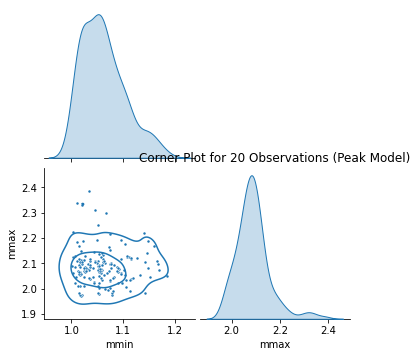

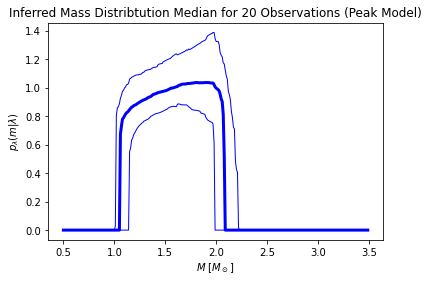

In [14]:
#corner plot

post_dat = np.genfromtxt(pop_mod+'.csv',delimiter=',',names=True,dtype=None)

params = post_dat.dtype.names[2:4] 
post = np.column_stack([post_dat[param] for param in params]) 
post_frame = pd.DataFrame(post,columns=params)

fig = sns.pairplot(post_frame, kind='scatter', markers='.', diag_kind='kde', corner=True, diag_kws=dict(lw=1,common_norm=False))
fig.map_lower(sns.kdeplot, levels=[0.1,0.5]) 

plt.title ('Corner Plot for 20 Observations (Peak Model)')
plt.show()

ppd_data = np.genfromtxt(pop_mod+'_ppd.csv',delimiter=',',names=True,dtype=None) 

colours = plt.rcParams['axes.prop_cycle'].by_key()['color'] # pyplot magic to get default colours

plt.plot(ppd_data['m'],ppd_data['med'],lw=3, color='b') # inferred mass distribution median 
plt.plot(ppd_data['m'],ppd_data['ub'],lw=1, color='b') #upper error bound
plt.plot(ppd_data['m'],ppd_data['lb'],lw=1, color='b') #lower error bound

plt.title ('Inferred Mass Distribtution Median for 20 Observations (Peak Model)')
plt.xlabel(r'$M$ [$M_\odot$]')
plt.ylabel(r'$p_\lambda(m|\lambda)$')
plt.show()